<a href="https://colab.research.google.com/github/aggrigorenko/sf_data_science/blob/main/%22FINAL_PROJECT_(Scoring)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="5">
Цель: создать модель оценки кредитоспособности, спрогнозировав вероятность того, что кто-то cтолкнется с финансовыми трудностями в ближайшие два года
</font>


<font size="5">Данные взяты из соревнования Kaggle. https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

<font size="5">  

In [192]:
!pip install -q tensorflow==2.11

In [193]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from scipy.stats import f_oneway

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import missingno as missno
import seaborn as sns
from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

# Часть 1. Знакомство с данными, обработка пропусков и выбросов

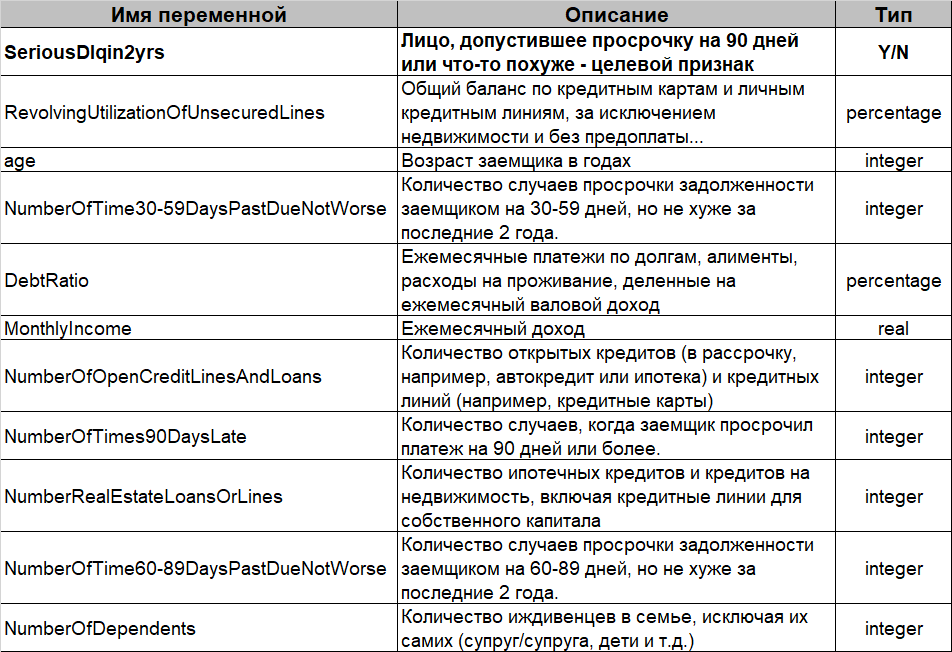

In [194]:
df = pd.read_csv('/content/drive/MyDrive/FINAL_PROJECT/scoring.csv', index_col='Unnamed: 0')
display(df.head())

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [195]:
# Переименование признаков
df.columns = ['Дефолт', 'Кредитный баланс(%)', 'Возраст', 'Кол. просрочек 30-59 дней',
              'Ежемесячные платежи(%)', 'Доход', 'Кол. кредитов', 'Кол. просрочек 90+ дней',
              'Кол. ипотек', 'Кол. просрочек 60-89 дней', 'Кол. иждевенцев']

# Перестановка признаков для удобства
df = df[['Кредитный баланс(%)', 'Возраст', 'Ежемесячные платежи(%)', 'Доход',
        'Кол. кредитов', 'Кол. ипотек', 'Кол. иждевенцев', 'Кол. просрочек 30-59 дней',
        'Кол. просрочек 60-89 дней', 'Кол. просрочек 90+ дней','Дефолт']]
display(df.head())            

,Кредитный баланс(%),Возраст,Ежемесячные платежи(%),Доход,Кол. кредитов,Кол. ипотек,Кол. иждевенцев,Кол. просрочек 30-59 дней,Кол. просрочек 60-89 дней,Кол. просрочек 90+ дней,Дефолт
1,0.766127,45,0.802982,9120.0,13,6,2.0,2,0,0,1
2,0.957151,40,0.121876,2600.0,4,0,1.0,0,0,0,0
3,0.658180,38,0.085113,3042.0,2,0,0.0,1,0,1,0
4,0.233810,30,0.036050,3300.0,5,0,0.0,0,0,0,0
5,0.907239,49,0.024926,63588.0,7,1,0.0,1,0,0,0


In [196]:
# поиск дубликатов
mask = df.duplicated()
duplicates = df[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
# удаление дубликатов
df = df.drop_duplicates();

Число найденных дубликатов: 609


In [197]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Кредитный баланс(%)        149391 non-null  float64
 1   Возраст                    149391 non-null  int64  
 2   Ежемесячные платежи(%)     149391 non-null  float64
 3   Доход                      120170 non-null  float64
 4   Кол. кредитов              149391 non-null  int64  
 5   Кол. ипотек                149391 non-null  int64  
 6   Кол. иждевенцев            145563 non-null  float64
 7   Кол. просрочек 30-59 дней  149391 non-null  int64  
 8   Кол. просрочек 60-89 дней  149391 non-null  int64  
 9   Кол. просрочек 90+ дней    149391 non-null  int64  
 10  Дефолт                     149391 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


None

<font size="5"> Модель без обработки данных

In [198]:
#           РЕШАЮЩЕЕ ДЕРЕВО
# Создаем копию датафрейма
df_temp = df.copy()
# Заменяем пропуски на медианные значения
df_temp['Доход'] = df_temp['Доход'].fillna(df_temp['Доход'].median())
df_temp['Кол. иждевенцев'] = df_temp['Кол. иждевенцев'] \
                            .fillna(df_temp['Кол. иждевенцев'].median())
# Разделяем днные 
X = df_temp.drop(['Дефолт'], axis=1)
y = df_temp['Дефолт'] 

# Создаём модель классификации решающего дерева, метрика - auc    
param_grid = {'min_samples_split': [1, 2, 3],
              'max_depth':[4, 5, 6],
              }      
grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'accuracy'
)  
%time grid_search_tree.fit(X, y) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))
print("Cреднее значение метрики лучшей выборки: accuracy={:.5f}".format(grid_search_tree.best_score_))

CPU times: user 1.06 s, sys: 199 ms, total: 1.26 s
Wall time: 21.6 s
Наилучшие значения гиперпараметров: {'max_depth': 5, 'min_samples_split': 2}
Cреднее значение метрики лучшей выборки: accuracy=0.93591


## 1.1 Обработка пропусков

Text(0.5, 1.0, 'Отсутствующие значения')

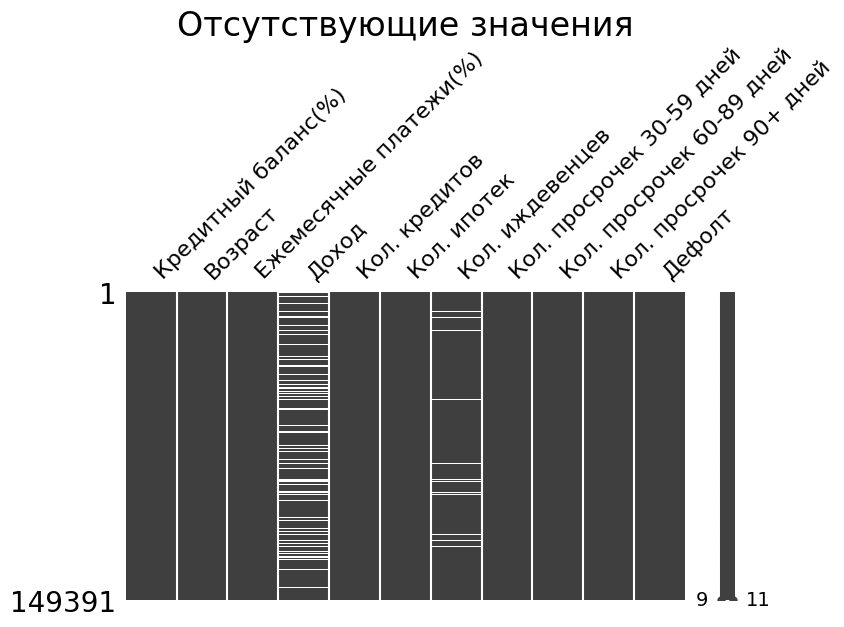

In [199]:
# наглядная карта пропусков
missno.matrix(df, figsize=(8, 4))
plt.title('Отсутствующие значения', size=24)

In [200]:
# Количество пропусков
display(df.isnull().sum())

Кредитный баланс(%)              0
Возраст                          0
Ежемесячные платежи(%)           0
Доход                        29221
Кол. кредитов                    0
Кол. ипотек                      0
Кол. иждевенцев               3828
Кол. просрочек 30-59 дней        0
Кол. просрочек 60-89 дней        0
Кол. просрочек 90+ дней          0
Дефолт                           0
dtype: int64

## Заполнение пропущенных значений в признаках "Доход" и "Кол. иждевенцев"  медианными значениями

Text(0.5, 1.0, 'Отсутствующие значения')

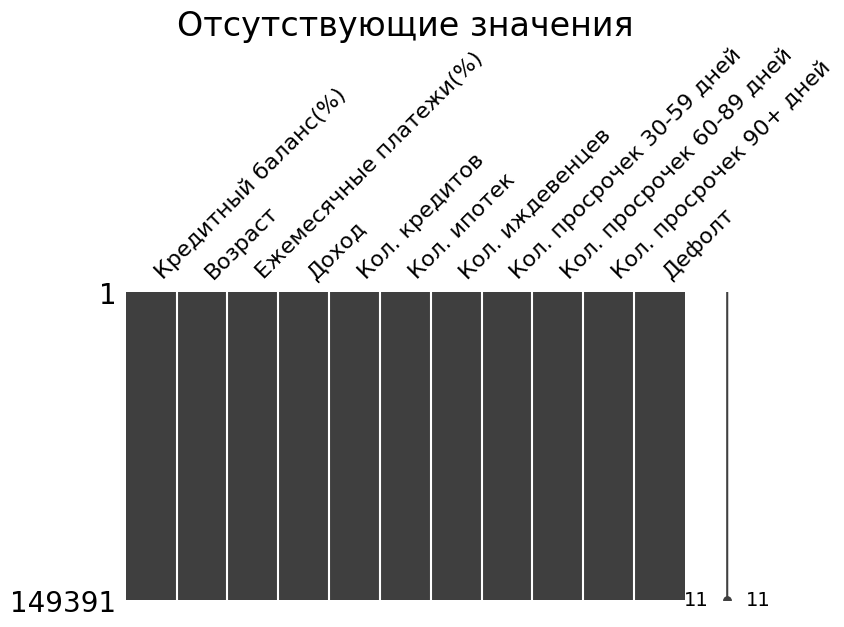

In [201]:
# Заполненяем пропущенные значения в признаках "Доход" и "Кол. иждевенцев" медианными значениями
df['Доход'] = df['Доход'] \
                    .fillna(df['Доход'].median())
df['Кол. иждевенцев'] = df['Кол. иждевенцев'] \
                    .fillna(df['Кол. иждевенцев'].median())                   

missno.matrix(df, figsize=(8, 4))
plt.title('Отсутствующие значения', size=24)                    

In [202]:
# Убеждаемся что пропусков нет
df.reset_index
display(df.isnull().sum())

Кредитный баланс(%)          0
Возраст                      0
Ежемесячные платежи(%)       0
Доход                        0
Кол. кредитов                0
Кол. ипотек                  0
Кол. иждевенцев              0
Кол. просрочек 30-59 дней    0
Кол. просрочек 60-89 дней    0
Кол. просрочек 90+ дней      0
Дефолт                       0
dtype: int64

## 1.2 Обработка выбросов

In [203]:
df.describe(include='all')

,Кредитный баланс(%),Возраст,Ежемесячные платежи(%),Доход,Кол. кредитов,Кол. ипотек,Кол. иждевенцев,Кол. просрочек 30-59 дней,Кол. просрочек 60-89 дней,Кол. просрочек 90+ дней,Дефолт
count,149391.000000,149391.000000,149391.000000,1.493910e+05,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000
mean,6.071087,52.306237,354.436740,6.425688e+03,8.480892,1.022391,0.740393,0.393886,0.212503,0.238120,0.066999
std,250.263672,14.725962,2041.843455,1.291567e+04,5.136515,1.130196,1.108272,3.852953,3.810523,3.826165,0.250021
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030132,41.000000,0.177441,3.900000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154235,52.000000,0.368234,5.400000e+03,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.556494,63.000000,0.875279,7.400000e+03,11.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,50708.000000,109.000000,329664.000000,3.008750e+06,58.000000,54.000000,20.000000,98.000000,98.000000,98.000000,1.000000


<font size="5"> Кредитный баланс </font>

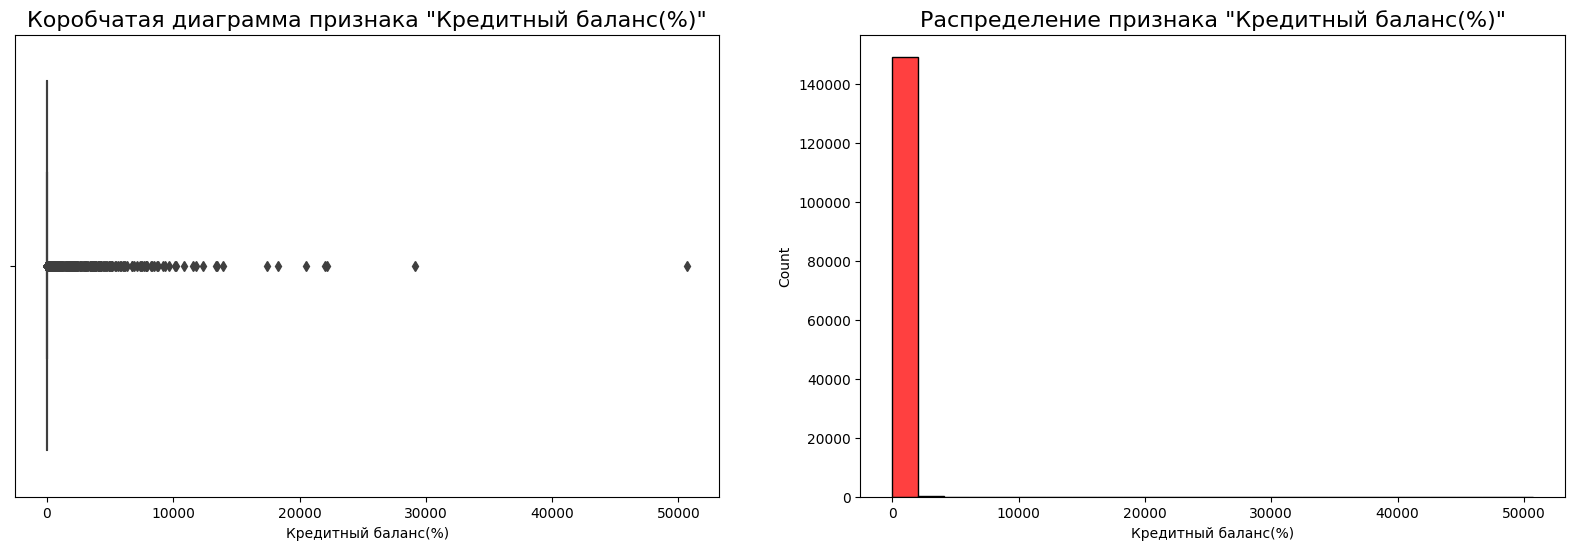

In [204]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Кредитный баланс(%)"', size=16)
sns.boxplot(data=df, x='Кредитный баланс(%)', ax = axes[0])
axes[1].set_title('Распределение признака "Кредитный баланс(%)"', size=16)
sns.histplot(data=df['Кредитный баланс(%)'],bins=25, color='red',ax=axes[1])
fig.show()

In [205]:
# Количество строк с Кредитным балансом боле 10
display(df[df['Кредитный баланс(%)'] > 10].shape[0])
# Удаляем строки с Кредитным балансом более 10 (более 10 карт с полным кредитным балансом)
df = df[df['Кредитный баланс(%)'] <= 10]

241

<font size="5"> Возраст 

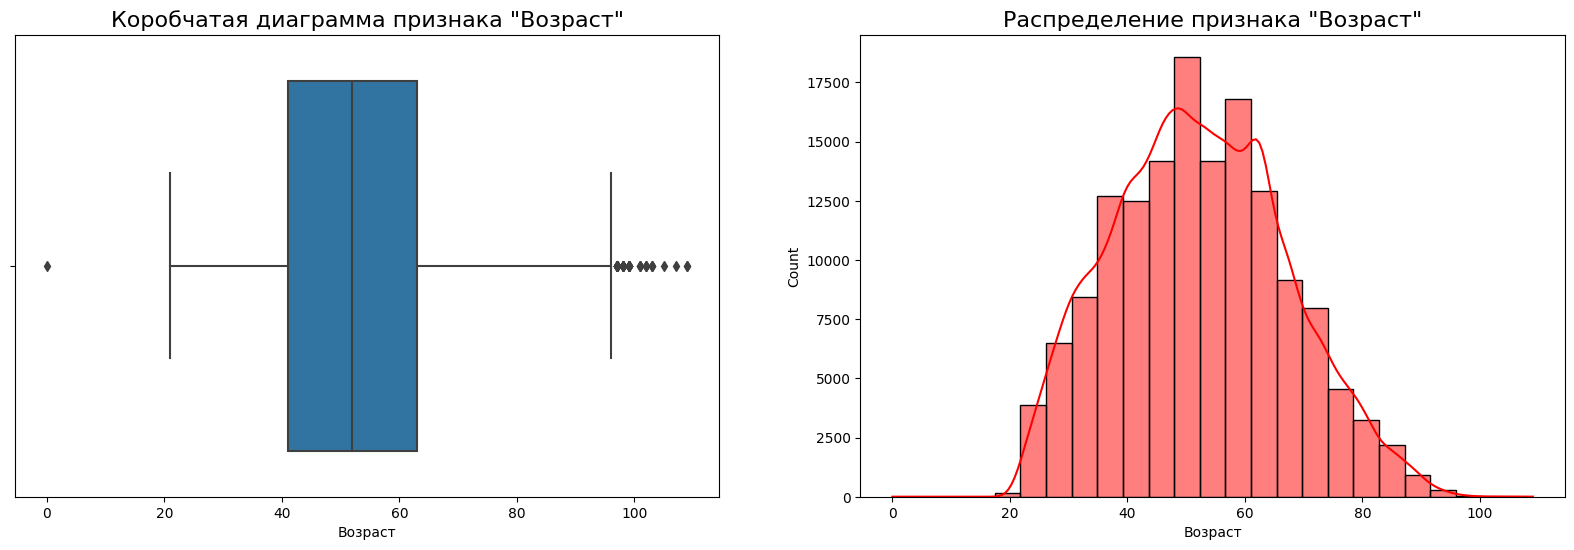

In [206]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Возраст"', size=16)
sns.boxplot(data=df, x='Возраст', ax = axes[0])
axes[1].set_title('Распределение признака "Возраст"', size=16)
sns.histplot(data=df['Возраст'],bins=25, kde=True, color='red',ax=axes[1])
fig.show()

In [207]:
# Удаляем строку с Возрастом = 0
df = df[df['Возраст'] > 0]

<font size="5"> Ежемесячные платежи(%)  </font>

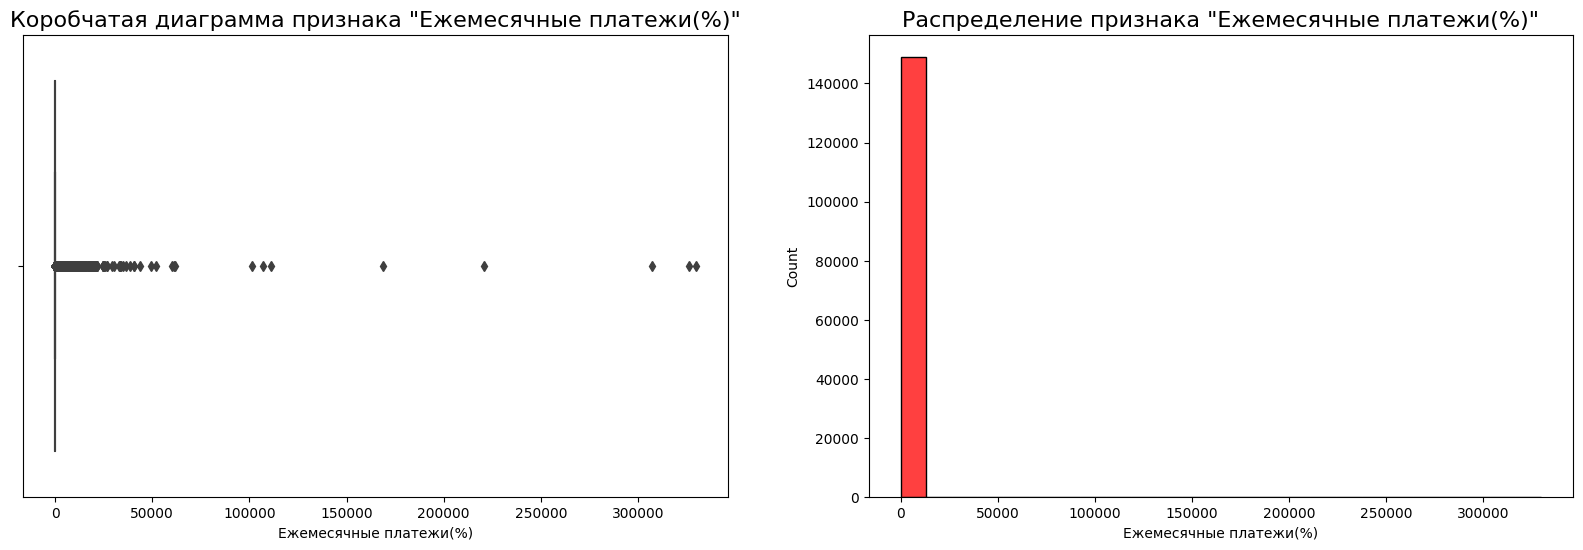

In [208]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Ежемесячные платежи(%)"', size=16)
sns.boxplot(data=df, x='Ежемесячные платежи(%)', ax = axes[0])
axes[1].set_title('Распределение признака "Ежемесячные платежи(%)"', size=16)
sns.histplot(data=df['Ежемесячные платежи(%)'],bins=25, kde=False, color='red',ax=axes[1])
fig.show()

In [209]:
# Количество строк с Ежемесячными платежами более 75000
display(df[df['Ежемесячные платежи(%)'] > 75000].count()[0])
# Удаляем строки с Ежемесячными платежами более 75000
df = df[df['Ежемесячные платежи(%)'] <= 75000]

8

<font size="5"> Доход </font>

<Axes: title={'center': 'Распределение признака "Доход"'}, xlabel='Доход', ylabel='Count'>

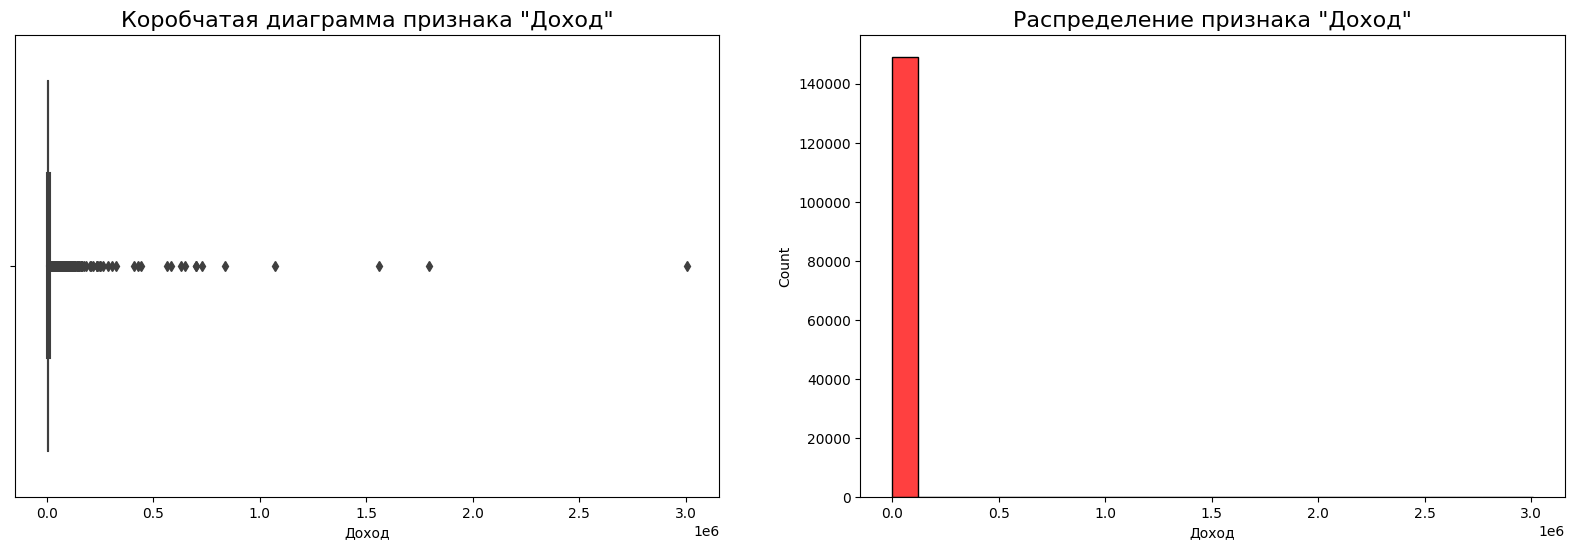

In [210]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Доход"', size=16)
sns.boxplot(data=df, x='Доход', ax = axes[0])
axes[1].set_title('Распределение признака "Доход"', size=16)
sns.histplot(data=df['Доход'],bins=25, kde=False, color='red',ax=axes[1])

<font size=5> Попробуем логарифмировать признак:</font>

<Axes: title={'center': 'Распределение признака "Доход"'}, xlabel='Доход', ylabel='Count'>

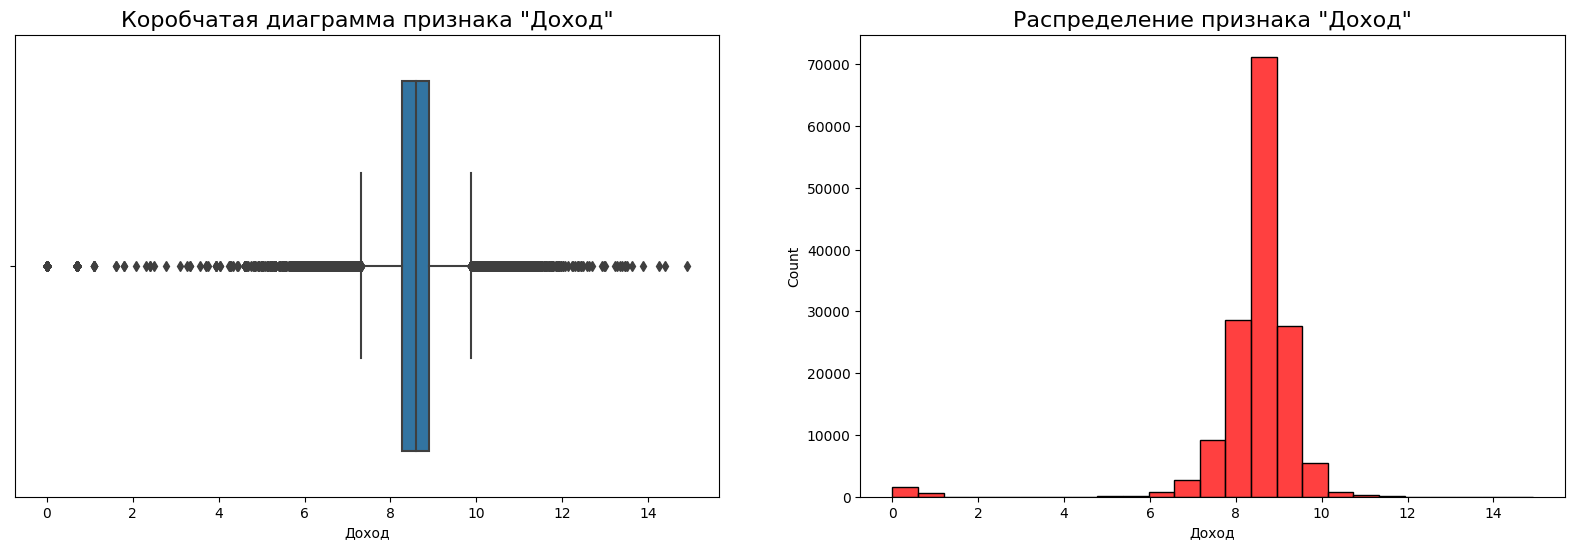

In [211]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Доход"', size=16)
sns.boxplot(data=df, x=np.log(df['Доход']+1), ax = axes[0])
axes[1].set_title('Распределение признака "Доход"', size=16)
sns.histplot(data=df, x=np.log(df['Доход']+1),bins=25, color='red', ax=axes[1])

In [212]:
# Применим метод Тьюки для очистки выбросов
x = np.log(df['Доход']+1)
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 3)
upper_bound = quartile_3 + (iqr * 3)
outliers = df[(x<lower_bound) | (x > upper_bound)]
cleaned = df[(x>lower_bound) & (x < upper_bound)]
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned
display(df['Доход'].describe())

Число выбросов по методу Тьюки: 3205
Результирующее число записей: 145936


count    145936.000000
mean       6298.049474
std        4104.602276
min         571.000000
25%        4000.000000
50%        5400.000000
75%        7488.000000
max       50500.000000
Name: Доход, dtype: float64

<font size="5"> Количество кредитов </font>

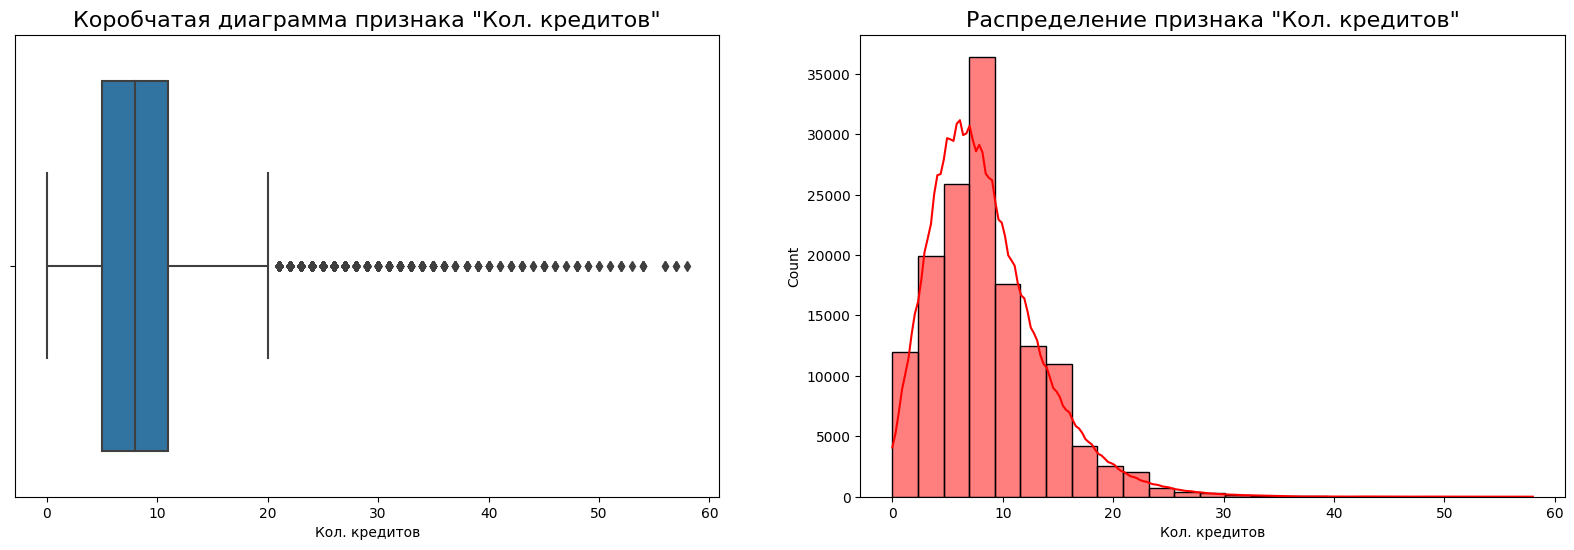

In [213]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Кол. кредитов"', size=16)
sns.boxplot(data=df, x='Кол. кредитов', ax = axes[0])
axes[1].set_title('Распределение признака "Кол. кредитов"', size=16)
sns.histplot(data=df['Кол. кредитов'],bins=25, kde=True, color='red',ax=axes[1])
fig.show()

<font size="5"> Количество ипотек </font>

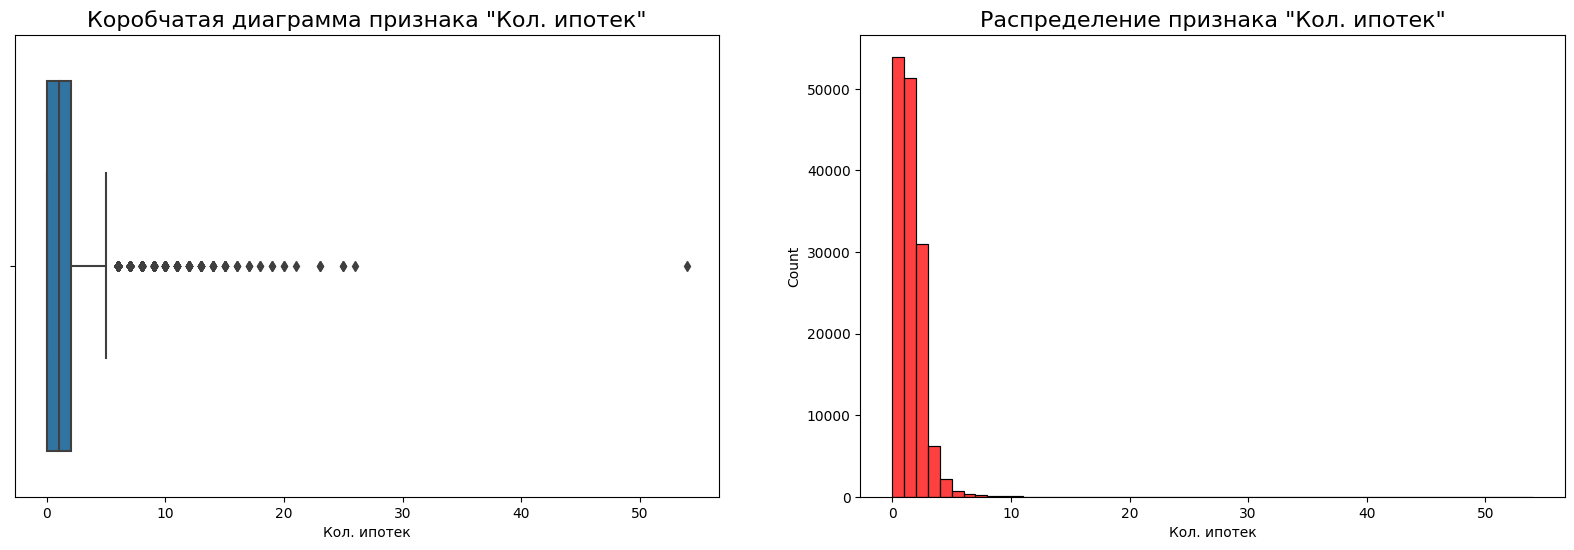

In [214]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Кол. ипотек"', size=16)
sns.boxplot(data=df, x='Кол. ипотек', ax = axes[0])
axes[1].set_title('Распределение признака "Кол. ипотек"', size=16)
sns.histplot(data=df['Кол. ипотек'],bins=54, kde=False, color='red',ax=axes[1])
fig.show()

In [215]:
# Количество строк с Количеством ипотек более 50
display(df[df['Кол. ипотек'] > 50].shape[0])
# Удаляем строку с Количеством ипотек более 50
df = df[df['Кол. ипотек'] < 50]

1

<font size="5"> Количество иждевенцев </font>

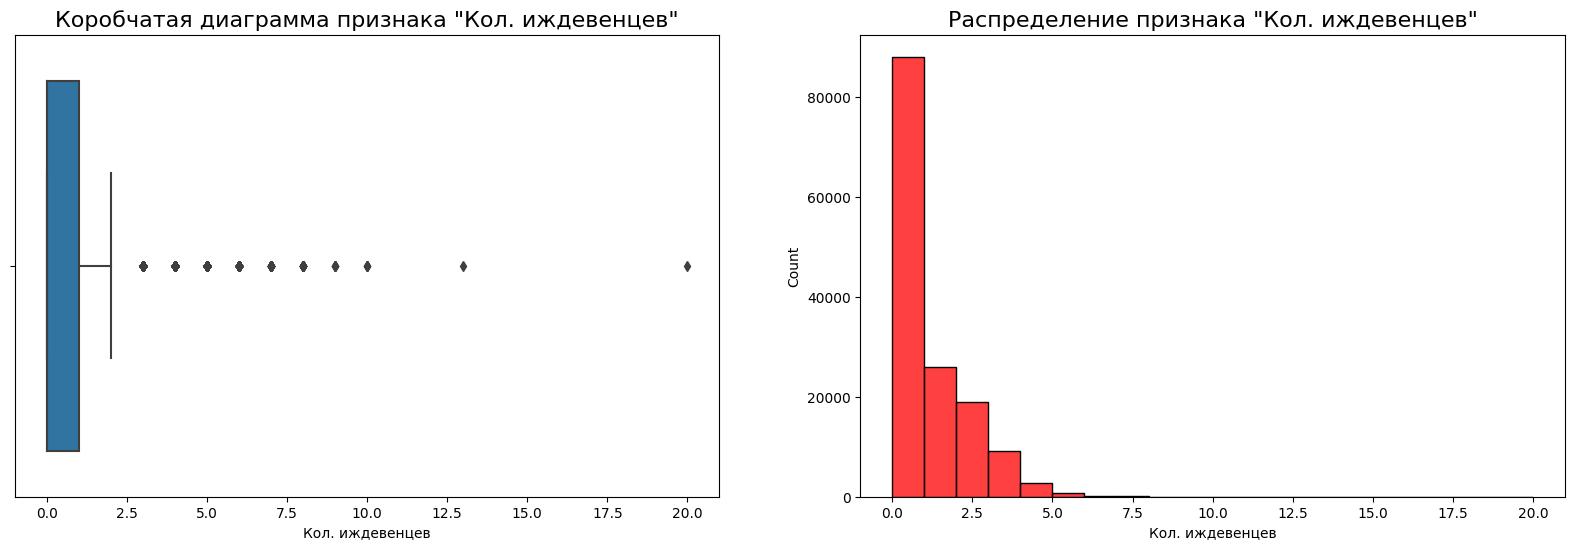

In [216]:
fig, axes = plt.subplots(1,2,figsize = (20, 6))
axes[0].set_title('Коробчатая диаграмма признака "Кол. иждевенцев"', size=16)
sns.boxplot(data=df, x='Кол. иждевенцев', ax = axes[0])
axes[1].set_title('Распределение признака "Кол. иждевенцев"', size=16)
sns.histplot(data=df['Кол. иждевенцев'],bins=20, kde=False, color='red',ax=axes[1])
fig.show()

<font size="5"> Количество просрочек </font>

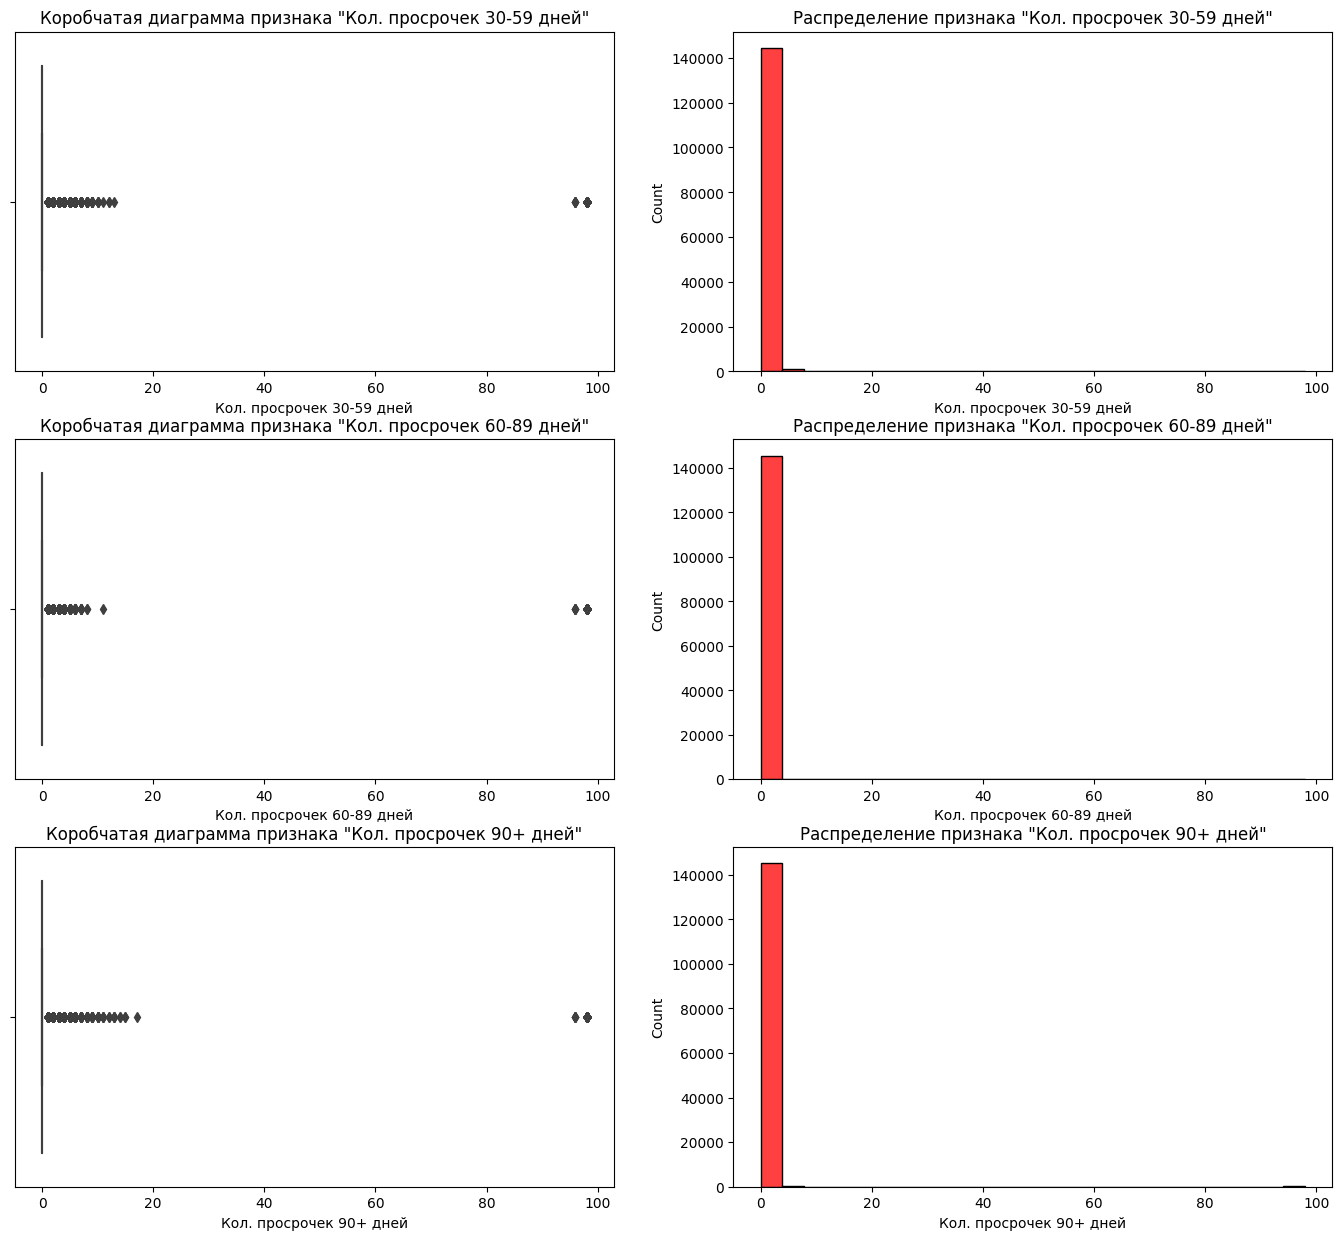

In [217]:
fig, axes = plt.subplots(3,2,figsize = (17, 15))
axes[0][0].set_title('Коробчатая диаграмма признака "Кол. просрочек 30-59 дней"', size=12)
sns.boxplot(data=df, x='Кол. просрочек 30-59 дней', ax = axes[0][0])
axes[0][1].set_title('Распределение признака "Кол. просрочек 30-59 дней"', size=12)
sns.histplot(data=df['Кол. просрочек 30-59 дней'],bins=25, kde=False, color='red',ax=axes[0][1])

axes[1][0].set_title('Коробчатая диаграмма признака "Кол. просрочек 60-89 дней"', size=12)
sns.boxplot(data=df, x='Кол. просрочек 60-89 дней', ax = axes[1][0])
axes[1][1].set_title('Распределение признака "Кол. просрочек 60-89 дней"', size=12)
sns.histplot(data=df['Кол. просрочек 60-89 дней'],bins=25, kde=False, color='red',ax=axes[1][1])

axes[2][0].set_title('Коробчатая диаграмма признака "Кол. просрочек 90+ дней"', size=12)
sns.boxplot(data=df, x='Кол. просрочек 90+ дней', ax = axes[2][0])
axes[2][1].set_title('Распределение признака "Кол. просрочек 90+ дней"', size=12)
sns.histplot(data=df['Кол. просрочек 90+ дней'],bins=25, kde=False, color='red',ax=axes[2][1])

fig.show()

In [218]:
# Количество строк с количеством просрочек более 80
display(df[(df['Кол. просрочек 30-59 дней'] > 80) |
           (df['Кол. просрочек 60-89 дней'] > 80) |
           (df['Кол. просрочек 90+ дней'] > 80)
           ].count()[0])

# Удаляем строки с количеством просрочек более 80
# df = df[(df['Кол. просрочек 30-59 дней'] <= 80) |
#        (df['Кол. просрочек 60-89 дней'] <= 80) |
#        (df['Кол. просрочек 90+ дней'] <= 80)]


213

<font size="4"> Удаление строк с просрочками более 80 сильно ухудшает метрику

# Часть 2. Разведывательный анализ

0    136078
1      9857
Name: Дефолт, dtype: int64

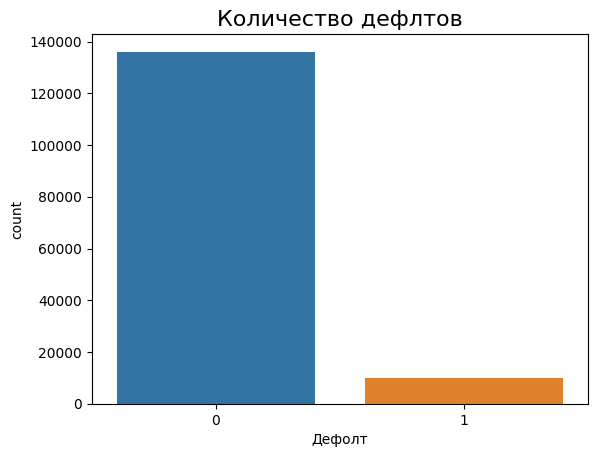

In [219]:
# Анализ сбалансированности классов в данных
display(df['Дефолт'].value_counts())
sns.countplot(data=df, x='Дефолт').set_title("Количество дефлтов", size=16);

<font size="5"> Данные не сбалансированны 
нужно следить, чтобы данные разбивались стратифицированно.

<Axes: >

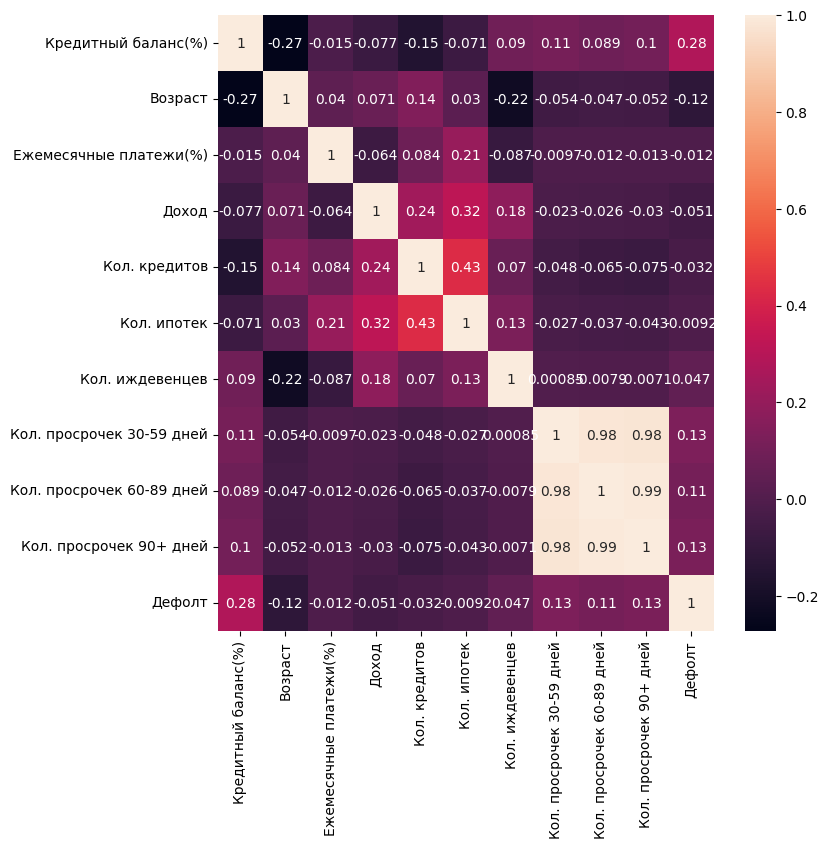

In [220]:
# строим корреляционную матрицу 
fig = plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True)

<font size="5"> Мультиколлинеарность в признаках с кличеством просрочек. 

In [221]:
# Избавляемся от мультиколлинеарности методом сложения признаков.
df['Кол. просрочек'] = df['Кол. просрочек 30-59 дней'] + \
                       df['Кол. просрочек 60-89 дней'] + \
                       df['Кол. просрочек 90+ дней']
# Удаляем признаки с количеством просрочек
df = df.drop(['Кол. просрочек 30-59 дней','Кол. просрочек 60-89 дней','Кол. просрочек 90+ дней'], axis=1)

<Axes: >

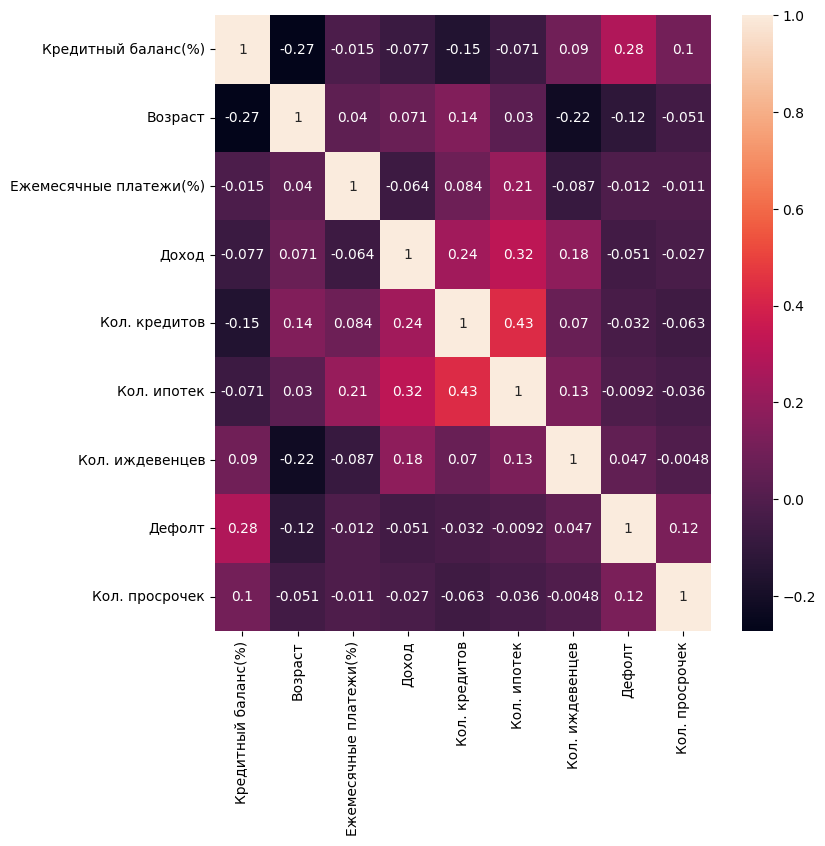

In [222]:
# строим корреляционную матрицу 
fig = plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True)

<font size="5"> Мультиколлинеарность отсутствует. 

## Статистические тесты

<font size="5">1. Гипотеза: люди до 30 лет в среднем более склонны к дефолтам. 

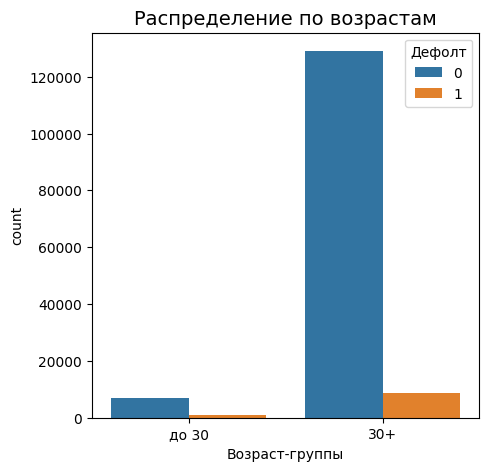

In [223]:
# создаём признак возрастных групп и определяем в каких группах более часты дефотлы
df['Возраст-группы'] = df['Возраст'].apply(lambda x: 'до 30' if x<30 else '30+')
# строим график
fig = plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Возраст-группы', hue='Дефолт',
            order=['до 30','30+']). \
            set_title("Распределение по возрастам", size=14)
#Удаляем признак Возраст-группы
df = df.drop('Возраст-группы', axis=1)

<font size="5">Для проверки гипотезы применим сравнительный ANOVA тест

In [224]:
# Установим уровень значимости
alpha = 0.05
before30 = df[df['Возраст'] < 30]['Дефолт']
after30 = df[df['Возраст'] >= 30]['Дефолт']

In [225]:
H0 = 'Нет значимой разницы между средними значениями дефолта.'
Ha = 'Есть значимая разница между средними значениями дефолта.'

In [226]:
_, p = f_oneway(before30, after30)
if p > alpha:
  print(f" {p:.3f} > {alpha}.", '\n', f"Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
  print(f" {p:.3f} <= {alpha}.", '\n', f"Мы отвергаем нулевую гипотезу. {Ha}")

 0.000 <= 0.05. 
 Мы отвергаем нулевую гипотезу. Есть значимая разница между средними значениями дефолта.


In [227]:
print("Средний показатель дефолта людей до 30 лет - ", before30.mean().round(2))
print("Средний показатель дефолта людей старше 30 лет - ", after30.mean().round(2))

Средний показатель дефолта людей до 30 лет -  0.12
Средний показатель дефолта людей старше 30 лет -  0.06


<font size="5">Вывод. Гипотеза подтверждается, люди до 30 лет в 2 раза более склонны к дефолту

<font size="5">2. Гипотеза: люди с доходом ниже медианного более склонны к дефоту.

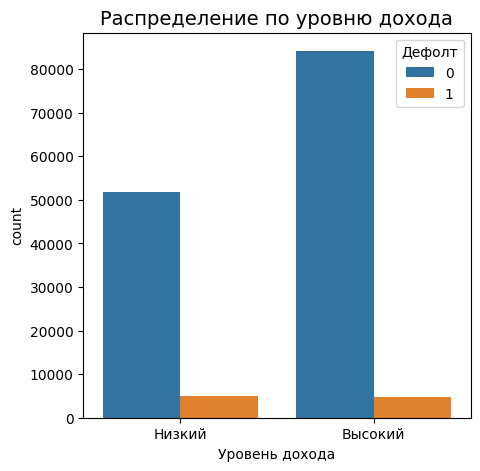

In [228]:
# создаём признак групп по уроню дохода и определяем в каких группах более часты дефотлы
sal_median = df['Доход'].median()
df['Уровень дохода'] = df['Доход'].apply(lambda x: 'Низкий' if x<sal_median else 'Высокий')
fig = plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Уровень дохода', hue='Дефолт',
            order=['Низкий','Высокий']). \
            set_title("Распределение по уровню дохода", size=14)
#Удаляем признак Уровень дохода
df = df.drop('Уровень дохода', axis=1)

<font size="5">Для проверки гипотезы применим сравнительный ANOVA тест

In [229]:
low = df[df['Доход'] < sal_median]['Дефолт']
high = df[df['Доход'] >= sal_median]['Дефолт']

In [230]:
_, p = f_oneway(low, high)
if p > alpha:
  print(f" {p:.3f} > {alpha}.", '\n', f"Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
  print(f" {p:.3f} <= {alpha}.", '\n', f"Мы отвергаем нулевую гипотезу. {Ha}")

 0.000 <= 0.05. 
 Мы отвергаем нулевую гипотезу. Есть значимая разница между средними значениями дефолта.


In [231]:
print("Средний показатель дефолта c низким уровнем дохода - ", low.mean().round(2))
print("Средний показатель дефолта c высоким уровнем дохода - ", high.mean().round(2))

Средний показатель дефолта c низким уровнем дохода -  0.09
Средний показатель дефолта c высоким уровнем дохода -  0.05


<font size="5">Вывод. Гипотеза подтверждается, люди с низким уровнем дохода почти в 2 раза более склонны к дефолту.

<font size="5">3. Гипотеза: люди без иждевенцев менее склонны к дефоту.

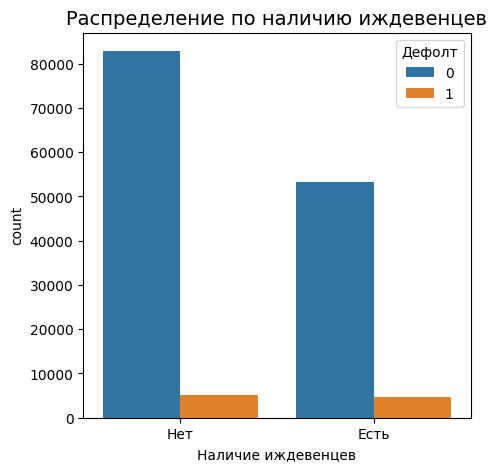

In [232]:
# создаём признак групп по наличию иждевенцев и определяем в каких группах более часты дефотлы
df['Наличие иждевенцев'] = df['Кол. иждевенцев'].apply(lambda x: 'Нет' if x==0 else 'Есть')
fig = plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Наличие иждевенцев', hue='Дефолт',
            order=['Нет','Есть']). \
            set_title("Распределение по наличию иждевенцев", size=14)
#Удаляем признак Наличие иждевенцев
df = df.drop('Наличие иждевенцев', axis=1)

<font size="5">Для проверки гипотезы применим сравнительный ANOVA тест

In [233]:
is_dep = df[df['Кол. иждевенцев'] == 0]['Дефолт']
no_dep = df[df['Кол. иждевенцев'] > 0]['Дефолт']

In [234]:
_, p = f_oneway(is_dep, no_dep)
if p > alpha:
  print(f" {p:.3f} > {alpha}.", '\n', f"Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
  print(f" {p:.3f} <= {alpha}.", '\n', f"Мы отвергаем нулевую гипотезу. {Ha}")

 0.000 <= 0.05. 
 Мы отвергаем нулевую гипотезу. Есть значимая разница между средними значениями дефолта.


In [235]:
print("Средний показатель дефолта людей без иждевенцев - ", is_dep.mean().round(2))
print("Средний показатель дефолта людей с иждевенцами - ", no_dep.mean().round(2))

Средний показатель дефолта людей без иждевенцев -  0.06
Средний показатель дефолта людей с иждевенцами -  0.08


<font size="5">Вывод. Гипотеза подтверждается, люди без иждевенцев в среднем на 25% менее склонны к дефолту.

# Часть 3. Преобразование данных

<font size="4"> Преобразуем признак 'Возраст' в категориальный, т.к. увеличение возраста не ведёт к увеличению или уменьшению вероятности дефолта.

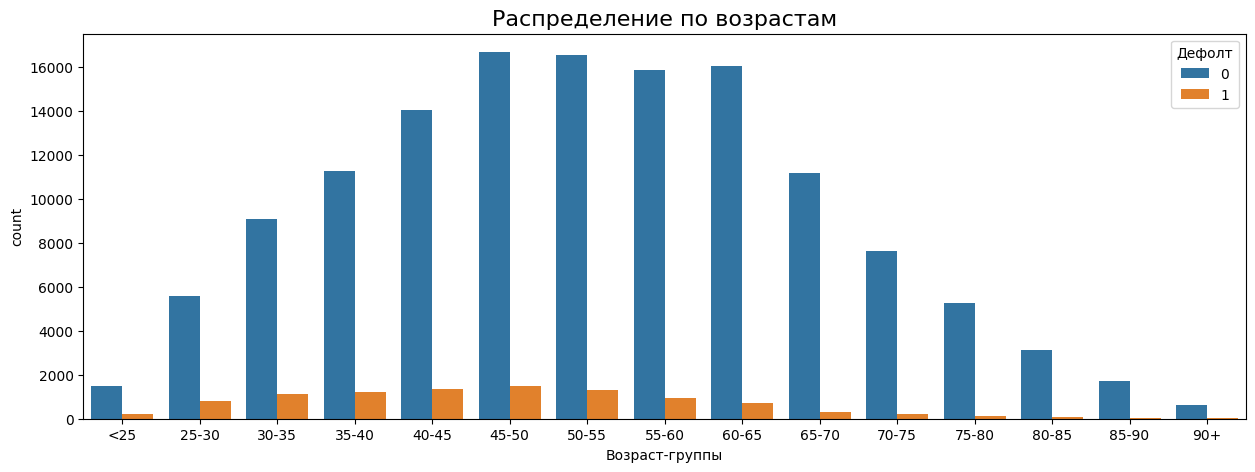

In [236]:
# создаём признак возрастных групп 
df['Возраст-группы'] = df['Возраст'].apply(lambda x: '<25' if x<25 else
                                 '25-30' if x>=25 and x<30 else
                                 '30-35' if x>=30 and x<35 else
                                 '35-40' if x>=35 and x<40 else
                                 '40-45' if x>=40 and x<45 else
                                 '45-50' if x>=45 and x<50 else
                                 '50-55' if x>=50 and x<55 else
                                 '55-60' if x>=55 and x<60 else
                                 '60-65' if x>=60 and x<65 else
                                 '65-70' if x>=65 and x<70 else
                                 '70-75' if x>=70 and x<75 else
                                 '75-80' if x>=75 and x<80 else
                                 '80-85' if x>=80 and x<85 else
                                 '85-90' if x>=85 and x<90 else
                                 '90+')
# строим график
fig = plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='Возраст-группы', hue='Дефолт',
            order=['<25','25-30','30-35','35-40','40-45','45-50','50-55','55-60',
                   '60-65','65-70','70-75','75-80','80-85','85-90','90+']). \
            set_title("Распределение по возрастам", size=16)

#Удаляем признак Возраст
df = df.drop('Возраст', axis=1)

In [237]:
# создаём дамми-переменные из признака Возраст-группы
df = pd.get_dummies(df, columns=['Возраст-группы'])      

In [238]:
# Разделяем данные со стратификацией по у
X = df.drop(['Дефолт'], axis=1)
y = df['Дефолт']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.25)

In [239]:
# с помощью SelectKBest отбераем 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
feature_names = selector.get_feature_names_out()
print(feature_names)
X_train = X_train[feature_names]
X_test = X_test[feature_names]

['Кредитный баланс(%)' 'Доход' 'Кол. кредитов' 'Кол. иждевенцев'
 'Кол. просрочек' 'Возраст-группы_25-30' 'Возраст-группы_30-35'
 'Возраст-группы_35-40' 'Возраст-группы_40-45' 'Возраст-группы_45-50'
 'Возраст-группы_60-65' 'Возраст-группы_65-70' 'Возраст-группы_70-75'
 'Возраст-группы_75-80' 'Возраст-группы_80-85']


In [240]:
# нормализуем данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4. Решение задачи классификации: логистическая регрессия и решающие деревья

In [49]:
#               ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

# Создаём модель классификации логистической регрессии, метрика - accuracy
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 0.1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 20, 
    n_jobs = -1,
    scoring = 'accuracy'
)  
%time random_search.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
#Выводим значения метрики 
y_train_pred = random_search.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
lr_test = metrics.accuracy_score(y_test, y_test_pred)

CPU times: user 1.82 s, sys: 275 ms, total: 2.09 s
Wall time: 1min 17s
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.06000000000000001}
accuracy на тренировочном наборе: 0.93257
accuracy на тестовом наборе: 0.93266


In [50]:
#           РЕШАЮЩЕЕ ДЕРЕВО

# Создаём модель классификации решающего дерева, метрика - accuracy    
param_grid = {'criterion':['gini', 'entropy'],
              'min_samples_split': [1, 2, 3],
              'max_depth':[3, 5, 7],
              }      
grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'accuracy'
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))
#Выводим значения метрики 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
dt_test = metrics.accuracy_score(y_test, y_test_pred)

CPU times: user 703 ms, sys: 143 ms, total: 846 ms
Wall time: 15.3 s
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
accuracy на тренировочном наборе: 0.93638
accuracy на тестовом наборе: 0.93619


# Часть 5. Решение задачи классификации: ансамбли моделей

In [51]:
#           СЛУЧАЙНЫЙ ЛЕС

# Создаём модель классификаци случайного леса, метрика - accuracy

param_distributions = {'criterion':['gini', 'entropy'],
                       'max_depth':[10, 12, 15],
                       'min_samples_split':[2, 3, 5]
                      } 

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_estimators = 100, random_state=42), 
    param_distributions=param_distributions,
    cv=5, 
    n_iter = 20,
    n_jobs = -1,
    scoring = 'accuracy'
)  
%time random_search.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
#Выводим значения метрики 
y_train_pred = random_search.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
rf_test = metrics.accuracy_score(y_test, y_test_pred)

CPU times: user 15.4 s, sys: 625 ms, total: 16 s
Wall time: 12min 28s
Наилучшие значения гиперпараметров: {'min_samples_split': 3, 'max_depth': 12, 'criterion': 'entropy'}
accuracy на тренировочном наборе: 0.94155
accuracy на тестовом наборе: 0.93592


In [188]:
#           ГРАДИЕНТНЫЙ БУСТИНГ
 
# Создаём модель классификаци градиентного бустинга, метрика - accuracy

param_distributions = {'max_depth':[1, 2, 3, 4],
                       'min_samples_split':[1, 3, 5, 7, 9, 11],
                       'learning_rate':list(np.linspace(0.01, 0.1, 10, dtype=float))
                      }

random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(n_estimators = 100, random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 20, 
    n_jobs = -1,
    scoring = 'accuracy'
)  
%time random_search.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
#Выводим значения метрики 
y_train_pred = random_search.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
gb_test = metrics.accuracy_score(y_test, y_test_pred)

CPU times: user 22.1 s, sys: 608 ms, total: 22.7 s
Wall time: 14min 27s
Наилучшие значения гиперпараметров: {'min_samples_split': 9, 'max_depth': 3, 'learning_rate': 0.04000000000000001}
accuracy на тренировочном наборе: 0.93675
accuracy на тестовом наборе: 0.93586


In [189]:
#               СТЕКИНГ

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
        ('rf', RandomForestClassifier(n_estimators=100,
                                      criterion='entropy',
                                      min_samples_split=3,
                                      max_depth=12,
                                      random_state=42)),
        ('lr', LogisticRegression(solver='sag',
                              penalty='l2', 
                              C=0.06, 
                              random_state=42,
                              max_iter=1000)),
    ('dt', DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=5,
                                  min_samples_split=2,
                                  random_state=42)),        
    ('gb', GradientBoostingClassifier(learning_rate=0.04, #темп обучения
                                      n_estimators=100, #число деревьев
                                      max_depth=3, #максимальная глубина дерева
                                      min_samples_split=9,
                                      random_state=42))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver='sag', random_state=42, max_iter=1000)
)
#Обучаем модель
reg.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = reg.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = reg.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
st_test = metrics.accuracy_score(y_test, y_test_pred)

accuracy на тренировочном наборе: 0.94098
accuracy на тестовом наборе: 0.93542


# Часть 6. Решение задачи классификации: нейронные сети MLP и Keras
<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="300">

## MLP (multilayer perceptron)

In [54]:
#   МНОГОСЛОЙНЫЙ ПЕРСЕПТРОН (много полносвязных слоев)
%%time
from sklearn.neural_network import MLPClassifier  
clf = MLPClassifier(max_iter=16, random_state=42)
clf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = clf.predict(X_train_scaled)
print('accuracy на тренировочном наборе: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = clf.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
mlp_test = metrics.accuracy_score(y_test, y_test_pred)

accuracy на тренировочном наборе: 0.93546
accuracy на тестовом наборе: 0.93622
CPU times: user 14 s, sys: 10.5 s, total: 24.5 s
Wall time: 16.9 s


## Керас

In [55]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.11.0
We are using Keras 2.11.0


In [56]:
# стандартизируем данные с помощью StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 2)
y_test_oh = keras.utils.to_categorical(y_test, 2)

In [58]:
clear_session()

In [59]:
# Архитектура сети
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(128, activation='relu',)) # третий скрытый слой
model.add(Dense(128, activation='relu',)) # четвёртый скрытый слой
model.add(Dense(2, activation='softmax',)) # выходной слой

In [60]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # оптимизатор
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [61]:
history = model.fit(X_train_scaled,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(X_test_scaled, y_test_oh)
                    )

Epoch 1/10
1711/1711 [==============================] - 10s 5ms/step - loss: 0.1967 - accuracy: 0.9338 - val_loss: 0.1875 - val_accuracy: 0.9344
Epoch 2/10
1711/1711 [==============================] - 8s 5ms/step - loss: 0.1867 - accuracy: 0.9353 - val_loss: 0.1898 - val_accuracy: 0.9358
Epoch 3/10
1711/1711 [==============================] - 8s 5ms/step - loss: 0.1854 - accuracy: 0.9355 - val_loss: 0.1845 - val_accuracy: 0.9358
Epoch 4/10
1711/1711 [==============================] - 8s 5ms/step - loss: 0.1846 - accuracy: 0.9355 - val_loss: 0.1856 - val_accuracy: 0.9352
Epoch 5/10
1711/1711 [==============================] - 6s 4ms/step - loss: 0.1839 - accuracy: 0.9354 - val_loss: 0.1847 - val_accuracy: 0.9355
Epoch 6/10
1711/1711 [==============================] - 10s 6ms/step - loss: 0.1833 - accuracy: 0.9361 - val_loss: 0.1840 - val_accuracy: 0.9356
Epoch 7/10
1711/1711 [==============================] - 7s 4ms/step - loss: 0.1831 - accuracy: 0.9360 - val_loss: 0.1842 - val_accurac

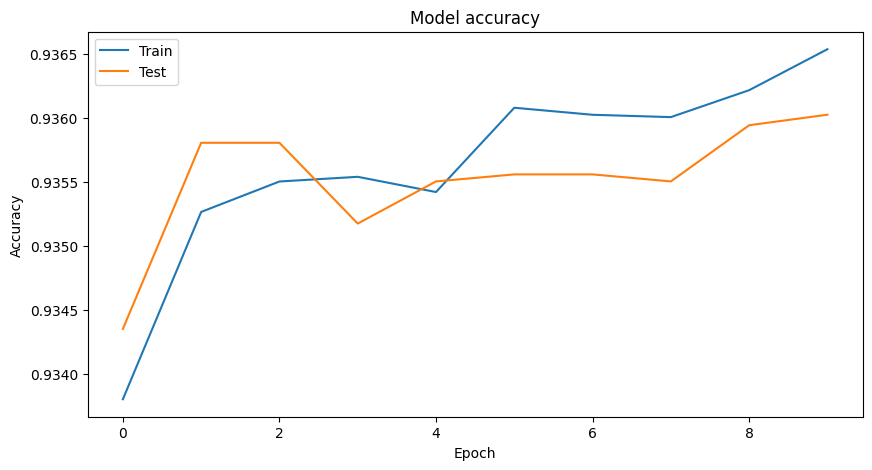

In [62]:
# Plot training & validation accuracy values
# plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [63]:
# предсказываем целевой признак и считаем метрику
predicts = np.argmax(model.predict(X_train_scaled), axis = 1)
print('Train Accuracy: ', accuracy_score(y_train, predicts).round(5))
predicts = np.argmax(model.predict(X_test_scaled), axis = 1)
print('Test Accuracy: ', accuracy_score(y_test, predicts).round(5))
kr_test = metrics.accuracy_score(y_test, predicts)

3421/3421 [==============================] - 6s 2ms/step
Train Accuracy:  0.93699
1141/1141 [==============================] - 2s 2ms/step
Test Accuracy:  0.93603


# Часть 7. Итоги

In [64]:
# Итоговая таблица
 
myTable = PrettyTable(["Модель", "Accuracy"])
 
myTable.add_row(["LogisticRegression", lr_test.round(5)])
myTable.add_row(["DecisionTreeClassifier", dt_test.round(5)])
myTable.add_row(["RandomForestClassifier", rf_test.round(5)])
myTable.add_row(["GradientBoostingClassifier", gb_test.round(5)])
myTable.add_row(["StackingClassifier", st_test.round(5)])
myTable.add_row(["MLPClassifier", mlp_test.round(5)])
myTable.add_row(["Tensorflow.Keras", kr_test.round(5)])
 
print(myTable)

+----------------------------+----------+
|           Модель           | Accuracy |
+----------------------------+----------+
|     LogisticRegression     | 0.93266  |
|   DecisionTreeClassifier   | 0.93619  |
|   RandomForestClassifier   | 0.93592  |
| GradientBoostingClassifier | 0.93586  |
|     StackingClassifier     | 0.93559  |
|       MLPClassifier        | 0.93622  |
|      Tensorflow.Keras      | 0.93603  |
+----------------------------+----------+


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     34020
           1       0.62      0.15      0.24      2464

    accuracy                           0.94     36484
   macro avg       0.78      0.57      0.60     36484
weighted avg       0.92      0.94      0.92     36484



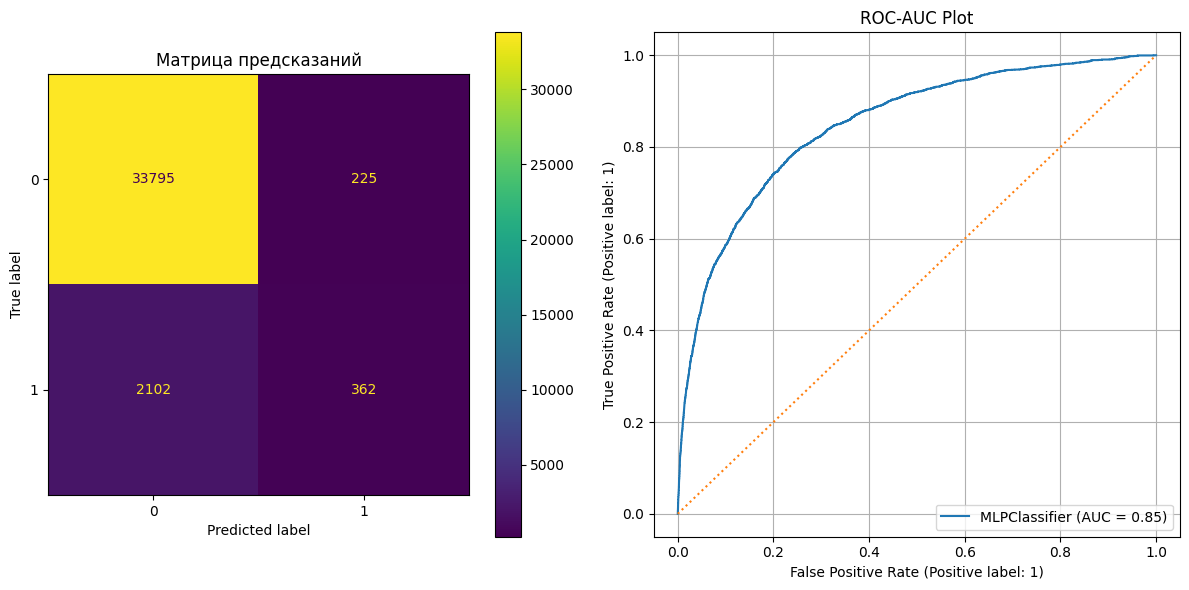

In [190]:
# Отчёт классификации

y_test_pred = clf.predict(X_test_scaled)
    
print('                 Classification Report')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_pred))
    
# Матрица предсказаний
fig, axes = plt.subplots(figsize = (12,6), ncols = 2)

cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot(ax = axes[0])
axes[0].set_title('Матрица предсказаний');
    
roc_auc_plot = RocCurveDisplay.from_estimator(clf, X_test_scaled, y_test, ax=axes[1])
axes[1].plot([0,1], [0,1], ls = ':')
axes[1].grid()
axes[1].set_title('ROC-AUC Plot')
fig.tight_layout()
plt.show()


<font size="5"> Основные итоги работы: 
1. Лучшая метрика Accuracy получилась у модели нейросети MLP (многослойный персептрон), Keras так же пару раз (всегда выдаёт разные результаты) выдавал лучшую метрику, подбором его архитектуры и параметров можно добиться высокой метрики. 
2. Вторая по величине метрика Accuracy получилась у решающего дерева. Если важна скорость работы кода, то лучше использовать его. 
</font>